## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import seaborn as sns
from itertools import chain
from skimage.io import imread,imshow
import matplotlib.image as mpimg #read png files
from scipy.ndimage import gaussian_filter
import scipy
from random import sample
import sklearn.model_selection as skl
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import binarize
# from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, 
# f1_score, average_precision_score, confusion_matrix
from sklearn.metrics import (roc_curve, auc, precision_recall_curve, average_precision_score,
plot_precision_recall_curve, f1_score, confusion_matrix, fbeta_score)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2751781739120592313
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7285084918265910200
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14951920436
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14619304634239527173
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10244233181818041635
physical_device_desc: "device: XLA_GPU device"
]


Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12002269834920043921
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 1801287382993159268
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14951920436
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9913501695106444867
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8295400143822695942
physical_device_desc: "device: XLA_GPU device"
]


In [3]:
! ls ../p1_data

ls: cannot access '../p1_data': No such file or directory


## Do some early processing of your metadata for easier model training:

In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

pd.set_option('display.max_columns', None)
all_xray_df.shape
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
34493,00009082_009.png,No Finding,9,9082,77,M,AP,2500,2048,0.168,0.168,NaN,/data/images_004/images/00009082_009.png
14509,00003770_010.png,No Finding,10,3770,57,M,PA,2500,2048,0.168,0.168,NaN,/data/images_002/images/00003770_010.png
1919,00000499_000.png,No Finding,0,499,28,F,AP,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000499_000.png


In [5]:
all_xray_df['path']

0         /data/images_001/images/00000001_000.png
1         /data/images_001/images/00000001_001.png
2         /data/images_001/images/00000001_002.png
3         /data/images_001/images/00000002_000.png
4         /data/images_001/images/00000003_000.png
                            ...                   
112115    /data/images_012/images/00030801_001.png
112116    /data/images_012/images/00030802_000.png
112117    /data/images_012/images/00030803_000.png
112118    /data/images_012/images/00030804_000.png
112119    /data/images_012/images/00030805_000.png
Name: path, Length: 112120, dtype: object

In [6]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo
all_labels=np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels=[x for x in all_labels if len(x) > 0]
print(all_labels)

for label in all_labels:
    if len(label)>1:  # leave out empty labels
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)

        
all_xray_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,/data/images_001/images/00000001_000.png,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,/data/images_001/images/00000001_001.png,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000001_002.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN,/data/images_001/images/00000002_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN,/data/images_001/images/00000003_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})

all_xray_df[all_xray_df['pneumonia_class']== 'Positive']

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000013_010.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Positive
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000032_012.png,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,0.168,NaN,/data/images_001/images/00000056_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Positive
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000061_012.png,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,Positive
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,0.139,NaN,/data/images_001/images/00000061_015.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111557,00030536_007.png,Atelectasis|Consolidation|Pneumonia,7,30536,56,F,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00030536_007.png,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
111627,00030570_001.png,Edema|Infiltration|Pneumonia,1,30570,29,F,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00030570_001.png,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
111767,00030621_002.png,Pneumonia,2,30621,22,F,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00030621_002.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
111845,00030637_016.png,Consolidation|Pneumonia,16,30637,48,M,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00030637_016.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive


In [8]:
# prevalence of pneumonia in the dataset
all_xray_df.Pneumonia.sum()/len(all_xray_df) * 100

1.2763110952550838

In [9]:
#drop entries with invalid age >100yrs of age
all_xray_df.shape
all_xray_df.drop(all_xray_df[all_xray_df['Patient Age'] >120].index, inplace = True) 
print ("maximum patient age with pneumonia: ",max(all_xray_df[all_xray_df.Pneumonia==1.0]['Patient Age']))
all_xray_df.shape

maximum patient age with pneumonia:  90


(112104, 29)

## Create your training and testing data:

In [10]:
def create_splits(vargs):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    
    #return train_data, val_data
    train_data, val_data=skl.train_test_split(vargs,
                                              test_size=0.2,
                                             stratify=vargs['Pneumonia'])
    
    #balance train_data
    p_ind=train_data[train_data['pneumonia_class']=='Positive'].index.tolist()
    n_ind=train_data[train_data['pneumonia_class']=='Negative'].index.tolist()
    n_sample = sample(n_ind,len(p_ind))
    train_data=train_data.loc[p_ind+n_sample]
    
    """balance val_data.  In the clinical setting where this algorithm will be deployed, 
    patients are being x-rayed based on their clinical symptoms that make Pneumonia 
    highly likely.  The prevalence of Pneumonia is about 20% of those who are x-rayed."""
    vp_ind=val_data[val_data['pneumonia_class']=='Positive'].index.tolist()
    vn_ind=val_data[val_data['pneumonia_class']=='Negative'].index.tolist()
    vn_sample = sample(vn_ind,4*len(vp_ind))
    val_data=val_data.loc[vp_ind+vn_sample]
    
    return train_data, val_data

In [11]:
train_data, val_data = create_splits(all_xray_df)

In [12]:
(train_data['pneumonia_class']=='Positive').value_counts()

True     1144
False    1144
Name: pneumonia_class, dtype: int64

In [13]:
(val_data['pneumonia_class']=='Negative').value_counts()

True     1144
False     286
Name: pneumonia_class, dtype: int64

Throw away data

In [14]:
p_inds = train_data[train_data.Pneumonia==1].index.tolist()
np_inds = train_data[train_data.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_data = train_data.loc[p_inds + np_sample]

In [15]:
train_data['Pneumonia'].sum()/len(train_data)

0.5

In [16]:
len(train_data)

2288

20% Positive Cases of Pneumonia

In [17]:
p_inds = val_data[val_data.Pneumonia==1].index.tolist()
np_inds = val_data[val_data.Pneumonia==0].index.tolist()
print("pneumonia count:    ", len(p_inds))
print("non-pneumonia count:", len(np_inds))

pneumonia count:     286
non-pneumonia count: 1144


In [18]:
np_sample = sample(np_inds, 4 * len(p_inds))
val_data = val_data.loc[p_inds + np_sample]

In [19]:
p_inds = val_data[val_data.Pneumonia==1].index.tolist()
np_inds = val_data[val_data.Pneumonia==0].index.tolist()
print("pneumonia count:    ", len(p_inds))
print("non-pneumonia count:", len(np_inds))
print("pneumonia %:        ", round(100 * len(p_inds) / (len(p_inds) + len(np_inds))))

pneumonia count:     286
non-pneumonia count: 1144
pneumonia %:         20


In [20]:
#check train_data distribution for changes in Age distribution of Males with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='M')],
                     train_data['Patient Age'][(train_data['Pneumonia']==True) & (train_data['Patient Gender']=='M')]
)

Ttest_indResult(statistic=0.34663429419349107, pvalue=0.7289147300186942)

In [21]:
#check train_data distribution for changes in Age distribution of Females with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='F')],
                     train_data['Patient Age'][(train_data['Pneumonia']==True) & (train_data['Patient Gender']=='F')]
)

Ttest_indResult(statistic=0.1299312038635272, pvalue=0.8966452546109939)

In [22]:
train_data['Patient Gender'].value_counts()

M    1316
F     972
Name: Patient Gender, dtype: int64

In [23]:
#check val_data distribution for changes in Age distribution of Males with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='M')],
                     val_data['Patient Age'][(val_data['Pneumonia']== True) & (val_data['Patient Gender']=='M')]
)

Ttest_indResult(statistic=-0.8334519328436506, pvalue=0.40478734036959096)

In [24]:
#check val_data distribution for changes in Age distribution of Females with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']== True) & (all_xray_df['Patient Gender']=='F')],
                     val_data['Patient Age'][(val_data['Pneumonia']==True) & (val_data['Patient Gender']=='F')]
)

Ttest_indResult(statistic=-0.3312348322217723, pvalue=0.7405656819630303)

In [25]:
val_data['Patient Gender'].value_counts()

M    813
F    617
Name: Patient Gender, dtype: int64

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [26]:
target_size = (224, 224)
batch_size = 32

In [27]:
def my_image_augmentation():
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_train_idg = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      height_shift_range = 0.1,
                                      width_shift_range = 0.1,
                                      rotation_range = 15,
                                      shear_range = 0.1,
                                      zoom_range = 0.1, 
                                      samplewise_center = True,
                                      samplewise_std_normalization = True
                                     )
    return my_train_idg

def my_image_augmentation_val():
    my_val_idg = ImageDataGenerator(rescale = 1./255.,
                                    samplewise_center=True,
                                    samplewise_std_normalization=True
                                    )
    return my_val_idg


def make_train_gen(my_train_idg, train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = target_size, 
                                          batch_size = 32
                                          )

    return train_gen


def make_val_gen(my_val_idg, val_df):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = target_size, 
                                              batch_size = 64,
                                              shuffle=False
                                             ) 
    
    return val_gen

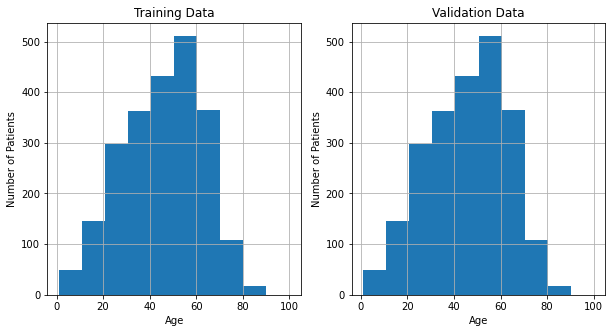

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(train_data['Patient Age'],range=(1,100))
ax[0].set_xlabel("Age")
ax[0].set_title("Training Data")
ax[0].set_ylabel("Number of Patients")
ax[0].grid("on")

ax[1].hist(train_data['Patient Age'],range=(1,100))
ax[1].set_xlabel("Age")
ax[1].set_title("Validation Data")
ax[1].set_ylabel("Number of Patients")
ax[1].grid("on")

plt.show()

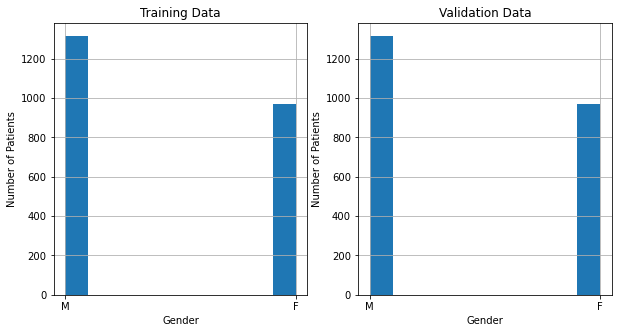

In [29]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(train_data['Patient Gender'])
ax[0].set_xlabel("Gender")
ax[0].set_title("Training Data")
ax[0].set_ylabel("Number of Patients")
ax[0].grid("on")

ax[1].hist(train_data['Patient Gender'])
ax[1].set_xlabel("Gender")
ax[1].set_title("Validation Data")
ax[1].set_ylabel("Number of Patients")
ax[1].grid("on")

plt.show()

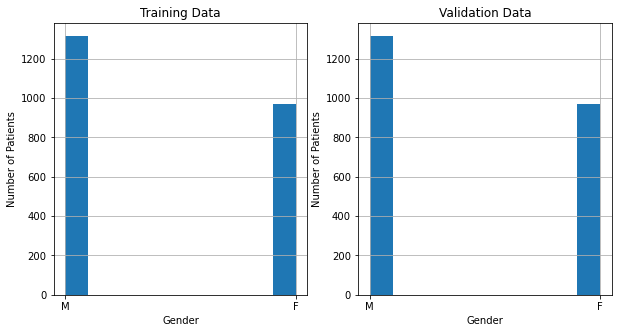

In [30]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(train_data['Patient Gender'])
ax[0].set_xlabel("Gender")
ax[0].set_title("Training Data")
ax[0].set_ylabel("Number of Patients")
ax[0].grid("on")

ax[1].hist(train_data['Patient Gender'])
ax[1].set_xlabel("Gender")
ax[1].set_title("Validation Data")
ax[1].set_ylabel("Number of Patients")
ax[1].grid("on")

plt.show()

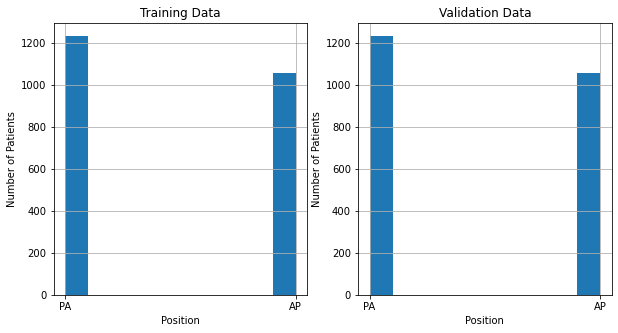

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax[0].hist(train_data['View Position'])
ax[0].set_xlabel("Position")
ax[0].set_title("Training Data")
ax[0].set_ylabel("Number of Patients")
ax[0].grid("on")

ax[1].hist(train_data['View Position'])
ax[1].set_xlabel("Position")
ax[1].set_title("Validation Data")
ax[1].set_ylabel("Number of Patients")
ax[1].grid("on")

plt.show()

In [32]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(my_image_augmentation_val(),val_data)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


In [33]:
valY

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [34]:
val_gen.labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


Found 2288 validated image filenames belonging to 2 classes.
shape (224, 224, 3)
Batch Mean: 3.3046113e-08 Batch Std: 0.9999952


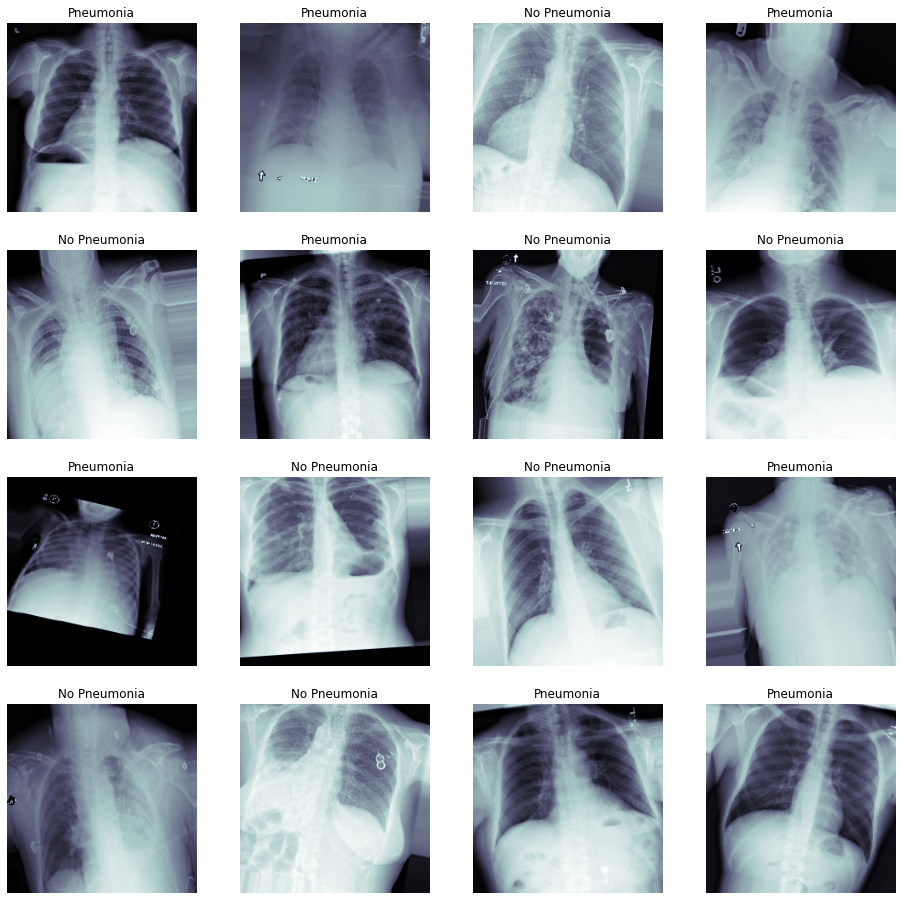

In [35]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

train_idg = my_image_augmentation() # train
train_gen = make_train_gen(train_idg, train_data)


t_x, t_y = next(train_gen)
print("shape", t_x[0].shape)
print("Batch Mean: " + str(t_x.mean()) + " Batch Std: " + str(t_x.std()))
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [36]:
def load_pretrained_model(layer_of_interest):
    
    # model = VGG16(include_top=True, weights='imagenet')
    # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    print(vgg_model.summary())
    
    for layer in vgg_model.layers[0:-2]:
        layer.trainable = False
    
    return vgg_model


In [37]:
# vgg_model = load_pretrained_model()
# vgg_model.summary()

In [38]:
def build_my_model(pretrained_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1024, activation = 'relu'))
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
        # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
#    my_model_history = my_model.fit_generator(train_gen, 
#                                             validation_data=(val_X, val_Y),
#                                             epochs=epochs)
    
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [39]:
#print(model.metrics_names)

In [40]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="out/{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss',  # CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min',  # CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
                             save_weights_only = True)


early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)
# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25,
                                  patience=3, min_lr=1e-5)
    
# return [checkpoint, early, reduce_lr]
callbacks_list = [checkpoint, early, reduce_lr]

### Start training! 

In [41]:


# Todo

vgg_model = load_pretrained_model('block5_pool')
vgg_model.summary()
my_model = build_my_model(vgg_model)


553467904/553467096 [==============================] - 3s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [42]:

my_model.summary()
## If you are reloading the notebook and do not want to rerun the training process, set run_training = False
# run_training = True
# if run_training:
#     t_start = time.time()
history = my_model.fit(train_gen, 
                       validation_data = (valX, valY),
                       epochs = 10,
                       shuffle = True,
                       callbacks = callbacks_list)



pd.DataFrame(history.history).to_csv("out/history.csv")
performance = []

# history = pd.read_csv('out/history.csv')
history_df=pd.DataFrame(history.history)
performance.append(history_df[history_df['val_loss']==min(history_df['val_loss'])])
performance
#     t_finish = time.time()
#     print(f'Training took {t_start - t_finish} seconds')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

[   val_loss  val_binary_accuracy      loss  binary_accuracy     lr
 6  0.608829                 0.75  0.637251         0.640734  0.001]

In [43]:
print('next')

next


In [ ]:
np.save('my_history.npy',history.history)

In [ ]:
history=np.load('my_history.npy',allow_pickle='TRUE').item()

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [46]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
weight_path
my_model.load_weights(weight_path)

#pred_Y = my_model.predict(val_gen, batch_size = 32, verbose = True)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

64/64 [==============================] - 0s 6ms/step


In [47]:
pred_Y.shape

(64, 1)

In [48]:
pred_Y


array([[0.64351946],
       [0.63883525],
       [0.34027937],
       [0.6432167 ],
       [0.45416996],
       [0.4343138 ],
       [0.5012445 ],
       [0.6022643 ],
       [0.53656334],
       [0.5550885 ],
       [0.6500828 ],
       [0.41874057],
       [0.6548026 ],
       [0.6823212 ],
       [0.23216243],
       [0.3667534 ],
       [0.6362286 ],
       [0.6398757 ],
       [0.53494656],
       [0.6494142 ],
       [0.32294244],
       [0.5331704 ],
       [0.3220547 ],
       [0.5841373 ],
       [0.63759375],
       [0.64028907],
       [0.17772536],
       [0.70862734],
       [0.6362286 ],
       [0.34818134],
       [0.7210982 ],
       [0.55086714],
       [0.627392  ],
       [0.23219877],
       [0.673033  ],
       [0.74271816],
       [0.72055995],
       [0.6431653 ],
       [0.5269685 ],
       [0.7176592 ],
       [0.66116214],
       [0.6430625 ],
       [0.6367233 ],
       [0.68839663],
       [0.7253148 ],
       [0.725117  ],
       [0.78017586],
       [0.456

In [49]:

val_gen.labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [50]:
valY.shape

(64,)

In [51]:
valY

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [52]:
# evaluate model
_, acc = my_model.evaluate_generator(val_gen, steps=len(val_gen), verbose=0)
print('Test Accuracy: %.3f' % (acc * 100))

Test Accuracy: 55.664


In [53]:
def plot_auc(t_y, p_y):
    
#     fig,ax = plt.subplots(1,1,figsize=(9,9))
#     fpr, tpr, thresholds = roc_curve(t_y, p_y)
#     ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
#     ax.legend()
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    fig.savefig('auc-plot.png')
    return

def plot_roc_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

In [54]:
plot_history(history)

TypeError: 'History' object is not subscriptable

<Figure size 432x288 with 0 Axes>

In [ ]:

plot_auc(valY, pred_Y)

In [ ]:
plot_precision_recall_curve(valY, pred_Y)

In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fpr, tpr, _ = roc_curve(t_y, p_y)
    plt.plot(fpr, tpr, label='Pneumonia')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

In [ ]:
plot_auc(valY, pred_Y)

In [ ]:
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')

In [ ]:
plot_precision_recall_curve(valY, pred_Y)

In [ ]:
plot_roc_curve(valY, pred_Y)

In [ ]:
precision, recall, thresholds = precision_recall_curve(valY,pred_Y)

In [ ]:
for id in range(len(precision)-2):
    print(f'p={precision[id]},r={recall[id]},thresh={thresholds[id]},F1 Score is: ' + str(calc_f1(precision[id],recall[id])))


In [ ]:
# Look at the threshold where precision is 0.55
precision_value = 0.33
idx = (np.abs(precision - precision_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

In [ ]:
# Look at the threshold where recall is 0.8
recall_value = 0.8
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))

In [ ]:
#tmp=pd.DataFrame(pred_Y)
tmp=pred_Y
t1=(tmp>0.27)
#t1 = t1.replace(True,1).replace(False,0)
testy=pred_Y.flatten()
t1=t1.flatten()
compare_t1 = (t1 == valY)
print('Accuracy at threshold: ' + str(len(compare_t1[compare_t1])/len(valY)))

F1

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
thresholds = np.linspace(0.0, 1.0, 100)
f1_scores = []
confusion_matrices = []
n = len(pred_Y)
f_beta_scores = []
for threshold in thresholds:
    gated_pred_y = [1 if pred >= threshold else 0 for pred in pred_Y]
    score = f1_score(list(valY), gated_pred_y)
    matrix = confusion_matrix(valY, gated_pred_y)
    confusion_matrices.append(matrix)
    f1_scores.append(score)
    beta_score = fbeta_score(list(valY), gated_pred_y, beta=1.5)
    f_beta_scores.append(beta_score)
plt.plot(thresholds, f1_scores)
plt.xlabel("Threshold")
plt.ylabel("F1-score");

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:16], valY[0:16], m_axs.flatten()):
     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
     if c_y == 1: 
         if pred_Y[i] > best_threshold:
             c_ax.set_title('actual: 1, pred: 1')
         else:
             c_ax.set_title('actual: 1, pred: 0')
     else:
         if pred_Y[i] > best_threshold: 
             c_ax.set_title('actual: 0, pred: 1')
         else:
             c_ax.set_title('actual: 0, pred: 0')
     c_ax.axis('off')
     i=i+1

Create Predictions

In [ ]:
pred_Y = pred_Y.flatten().tolist()

In [ ]:
predictions_df=pd.DataFrame({'Label':val_gen.labels,'Predict':pd.Series(pred_Y)})
predictions_df.sort_values('Label',ascending=False).head(10)

In [ ]:
predictions_df[predictions_df['Label']==1.0]

In [ ]:
predictions_df.to_csv('out/Predictions_best_model.csv')

In [ ]:
predictions_df= pd.read_csv('out/Predictions_best_model.csv')
predictions_df

In [ ]:
def plot_history(history,epoch):
    plt.style.use('ggplot')
    plt.figure(figsize=(12,12))
    plt.style.use('ggplot')
    plt.plot(range(epoch),history.history['loss'],label='Loss', color='green')
    plt.plot(range(epoch),history.history['val_loss'],label='Validation_Loss', color = 'red')
    plt.plot(range(epoch),history.history['binary_accuracy'],label='Binary_Accuracy',color='blue')
    plt.plot(range(epoch),history.history['val_binary_accuracy'],label='Validation_Bin_Accuracy',color='purple')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.savefig('out/Model_Training_Performance')
    plt.show()

    return

In [ ]:
plot_history(history,10)

In [ ]:
# https://knowledge.udacity.com/questions/231223
def plot_auc(t_y, p_y):
    
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    plt.show()
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
def plot_f1(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    f1_scores = []
    thresholds = []
    max_f1 = 0
    best_threshold = None
    for t in np.arange(0.0,1,0.01):        
        y_pred_class = p_y > t
        f1 = f1_score(t_y, y_pred_class)
        if max_f1 < f1:
            max_f1 = f1
            best_threshold = t
        f1_scores.append(f1)
        thresholds.append(t)
    
    c_ax.plot(thresholds, f1_scores,
              label = '%s (Best F1 Score:%0.2f with threshold %.2f)'  % ('Pneumonia', max_f1, best_threshold))
    c_ax.legend()
    c_ax.set_xlabel('threshold')
    c_ax.set_ylabel('f1')

In [ ]:
# again
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (5, 5))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend(['Pneumonia (AUC: {:.3f})'.format(auc(fpr, tpr))], loc='lower right')
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return


## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    fig, ax = plt.subplots(1,1, figsize = (10, 10))
    ax.plot(history.history['binary_accuracy'], label='train_acc')
    ax.plot(history.history['val_binary_accuracy'], label='val_acc')
    ax.plot(history.history['loss'], label='train_loss')
    ax.plot(history.history['val_loss'], label='val_loss')
    #ax.title('model loss')
    #ax.title("Training Loss and Accuracy on Dataset")
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['train_acc', 'val_acc', 'train_loss', 'val_loss'], loc="lower right")
    ax.savefig('out/Training_Loss_And_Accuracy_on_Dataset')
    return

In [ ]:
plot_auc(valY, pred_Y)

In [ ]:
plot_history(history)

In [ ]:
## plot figures

# Todo

def plot_history(history, epoch):
    plt.style.use('ggplot')
    plt.figure(figsize=(12,12))
    plt.style.use('ggplot')
    plt.plot(range(epoch),history.history['loss'],label='Loss', color='green')
    plt.plot(range(epoch),history.history['val_loss'],label='Validation_Loss', color = 'red')
    plt.plot(range(epoch),history.history['binary_accuracy'],label='Binary_Accuracy',color='blue')
    plt.plot(range(epoch),history.history['val_binary_accuracy'],label='Validation_Bin_Accuracy',color='purple')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.savefig('out/Model_Training_Performance')
    plt.show()

    return

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1)
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (Avr Precision Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Precision')
    c_ax.set_ylabel('Recall')

    return precision, recall, thresholds
    

precision, recall, thresholds = plot_pr(valY, pred_Y)

In [ ]:
def plot_precision_recall_curve(t_y, p_y):
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    plt.plot(recall, precision , label='Pneumonia')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title("Precision-Recall Curve")
    plt.legend(['Pneumonia'], loc='lower right')
    plt.show()

    return precision, recall, thresholds

In [ ]:

precision, recall, thresholds = plot_precision_recall_curve(valY, pred_Y)
precision = np.array(precision)
recall = np.array(recall)
f1_score = 2 * (precision*recall)/(precision+recall)

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# metric_df = pd.DataFrame({'f1':f1[:-1], 'prec':prec[:-1], 'recall':recall[:-1], 'thresholds':thresholds})

In [ ]:
metric_df

In [ ]:
metric_df.plot(x ='thresholds', y='f1', kind = 'line')

In [ ]:
precision = np.array(precision)
recall = np.array(recall)
f1_score = 2 * (precision*recall)/(precision+recall)

def plot_score_thresholds(precision, recall, f1_score, thresholds):
    plt.plot(thresholds, precision, label='Precision')
    plt.plot(thresholds, recall, label ='Recall')
    plt.plot(thresholds, f1_score, label = 'F1 score')
    plt.xlabel('Thresholds')
    plt.ylabel('Precision / Recall / F1')
    plt.title("Precision / Recall / F1 and Thresholds")
    plt.legend(['Precision', 'Recall', 'F1 score'], loc='upper right')
    plt.show()
plot_score_thresholds(precision[:-1], recall[:-1], f1_score[:-1], thresholds)

In [ ]:
print("Max F1 score: {}".format(max(f1_score)))

def calc_f1(t_y, p_y):
    prec, recall, thresholds = precision_recall_curve(t_y, p_y)
    return 2*(prec*recall)/(prec+recall), prec, recall, thresholds

f1, prec, recall, thresholds = calc_f1(valY, pred_Y)

metric_df = pd.DataFrame({'f1':f1[:-1], 'prec':prec[:-1], 'recall':recall[:-1], 'thresholds':thresholds})

threshold = metric_df.iloc[metric_df['f1'].idxmax()]['thresholds']
print('threshold corresponding to max f1:', threshold)

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

max_f1 = max(f1_score)
print("Max F1 Score: {}".format(max_f1))
threshold = thresholds[f1_score.argmax()]
print("Threshold corresponding to max F1: {}".format(threshold))

In [ ]:
def get_best_thresholds_precision(valY, pred_Y):
    df = pd.DataFrame(columns=['threshold_type', 'threshold_value', 'precision', 'recall', 'f1'])
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
    for i in np.arange(0,1,.2):
        precision_value = i
        idx = (np.abs(precision - precision_value)).argmin()
        data_dict = {
            'threshold_type': 'precision',
            'threshold_value': i,
            'precision': precision[idx],
            'recall': recall[idx],
            'f1': calc_f1(precision[idx],recall[idx]),
        }
        df = df.append(data_dict, ignore_index=True)
    return df

In [ ]:
def get_best_thresholds_recall(valY, pred_Y):
    df = pd.DataFrame(columns=['threshold_type', 'threshold_value', 'precision', 'recall', 'f1'])
    precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
    for i in np.arange(0,1,.2):
        recall_value = i
        idx = (np.abs(recall - recall_value)).argmin()
        data_dict = {
            'threshold_type': 'recall',
            'threshold_value': i,
            'precision': precision[idx],
            'recall': recall[idx],
            'f1': calc_f1(precision[idx],recall[idx]),
        }
        df = df.append(data_dict, ignore_index=True)
    return df

In [ ]:
precision_df = get_best_thresholds_precision(valY, pred_Y)
recall_df = get_best_thresholds_recall(valY, pred_Y)
thresh_df = precision_df.append(recall_df)
thresh_df

In [ ]:
testX, testY = val_gen.next()

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(testX[0:100], testY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
predicted_Y = [ 1 if x > 0.4 else 0 for x in pred_Y]

In [ ]:
predicted_Y = [ 1 if x > 0.4 else 0 for x in pred_Y]
precision = precision_score(valY, predicted_Y)
print("Threshold of 0.4 is ",precision)

In [ ]:
from sklearn.metrics import f1_score
predicted_Y = [ 1 if x > 0.53 else 0 for x in pred_Y]
f1score = f1_score(valY, predicted_Y, average='weighted')
print(f1score)

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
optimal_model_threshold = 0.53
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX_newset[0:100], valY_newset[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y_newset[i] > optimal_model_threshold:
            c_ax.set_title('1, 1')
        else:
             c_ax.set_title('1, 0')
    else:
        if pred_Y_newset[i] > optimal_model_threshold: 
                 c_ax.set_title('0, 1')
        else:
                 c_ax.set_title('0, 0')
        c_ax.axis('off')
        i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
print(model_json)
with open("out/my_model.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = False, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 3, 
                              shear_range = 0.1,
                              zoom_range=0.1,
                              fill_mode='nearest',
                              brightness_range=[0.9,1.1])

In [ ]:
val_test_idg = ImageDataGenerator(rescale=1. / 255.)

In [ ]:
test_gen = val_test_idg.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
                                         class_mode = 'raw',
                                         target_size = (224, 224), 
                                         batch_size = 465,
                                         seed=1000)

In [ ]:
testX, testY = test_gen.next()

In [ ]:
fig, m_axs = plt.subplots(4, 4,  figsize=(16, 16))

random_indexes = [random.randint(0, len(testX)) for i in range(16)]

for index, ax in zip(random_indexes, m_axs.flatten()):
    
    # Image description 
    prediction = y_pred[index][0]
    
    if (prediction > thresh) == bool(testY[index]):
        color = 'k'
    else:
        color = 'r'
        
    ax.set_title(f'Label: {testY[index]:.0f}, Prediction: {prediction:.2f}', color=color)
    
    # Grad-Cam
    last_conv = model.get_layer('block5_conv3')
    grads = K.gradients(model.output, last_conv.output)[0]
    pooled_grads = K.mean(grads, axis=(0,1,2))
    iterate = K.function([model.input], [pooled_grads, last_conv.output[0]])
    test_preprocessed = np.expand_dims(testX[index] ,axis=0)
    pooled_grads_value, conv_layer_output = iterate([test_preprocessed])

    for i in range(224):
        conv_layer_output[:,:,i] *= pooled_grads_value[i]
    heatmap = np.mean(conv_layer_output,axis=-1)

    # Apply ReLU function
    for x in range(heatmap.shape[0]):
        for y in range(heatmap.shape[1]):
            heatmap[x,y] = np.max(heatmap[x,y],0)

    # Standardize
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    
    # Plot 
    upsample = resize(heatmap, (224, 224), preserve_range=True)
    ax.imshow(testX[index][:,:,0], cmap='bone')
    ax.imshow(upsample, alpha=0.5)
    ax.axis('off')